In [12]:
import mxnet as mx
from mxnet import nd
from mxnet.gluon import nn

We want to build models with more complex data flows than simply passing data from one block to the next. The `nn.Block` class provides the functionality required for much of what we need. It is a model constructor provided in the `nn` module, which we can integrate to define the model we want.

In [19]:
class MLP(nn.Block):

    def __init__(self, hidden_units=256, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.hidden = nn.Dense(hidden_units, activation='relu')
        self.output = nn.Dense(10) # Output layer

    def forward(self, x):
        y = self.hidden(x)
        return self.output(y)

The MLP class inherits the `nn.Block` class to construct a simple sequential network which is made of only stacked fully connected layer. We will call our custom block MLP, for multilayer perceptron. It is just another name for a fully connected neural network. 

The MLP class overrides the `_init_` function and also the `forward` function. They are used to create model parameters and define forward computation, respectively. Since this model is just made of stacked fully connected layers, we could have built this model with a sequential block. But using the Block class gives us more flexibility.

The `forward` method describes how data flows through the network. First, we evaluate the hidden layer using `self.hidden`. And subsequently, we evaluate the output layer using `self.output`. 

In order for the block to know what it needs to evaluate, we first need to define its components. This is what the `_init_` method does. It creates all of the block related parameters and the requested layers, and attaches its layer and the required parameters to the class.

Note that there is no need to define a backpropagation method in the class.
The system automatically generates a backward method needed for
backpropagation by automatically generating the backward computation using
automatic differentiation. 

Let's create an instance of this network with 512 hidden units. Then we initialize the network, and then we pass dummy data through the network.

In [20]:
net = MLP(hidden_units=512)
net.initialize()
net(nd.random.uniform(shape=(1,64)))


[[ 0.08138503  0.03904303 -0.00392807  0.02940813  0.06713198  0.21919417
  -0.03509752  0.22010326  0.03273889 -0.09916696]]
<NDArray 1x10 @cpu(0)>

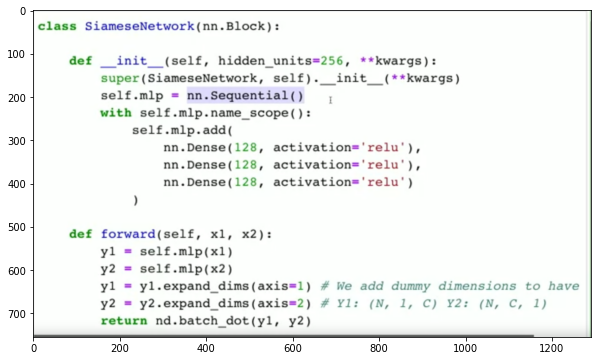

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread('2020-10-25_21-05-43.png'))

Now let's build a more complex network, for example, a Siamese network, which is a common architecture for comparing two images. Our example Siamese network takes two inputs, x1 and x2, and passes through the same dense network. Then multiply the output together using the dot product operation.

In [27]:
class  SiameseNetwork(nn.Block):

    def __init__(self, hidden_units=256, **kwargs):
        super(SiameseNetwork, self).__init__(**kwargs)
        self.mlp = nn.Sequential()
        with self.mlp.name_scope():
            self.mlp.add(
            nn.Dense(128, activation='relu'),
            nn.Dense(128, activation='relu'),
            nn.Dense(128, activation='relu')
        )

    def forward(self, x1, x2):
        y1 = self.mlp(x1)
        y2 = self.mlp(x2)
        y1 = y1.expand_dims(axis = 1) # We add dummy dimensions to have
        y2 = y2.expand_dims(axis = 2) # Y1: (N, 1, C) Y2: (N, C, 1)
        return nd.batch_dot(y1,y2)

In the `init` function, we create the MLP component of the network and add three layers to it. We are using a sequential block for this, which indicates just how flexible extending block is. A sequential which is a fully fledged network on its own can be used as a subcomponent or subnetwork inside another block.This block that we are defining here can also be used as a component in an even larger neural network, and so on.

Back to our Siamese network, you can see that the `forward` function now takes two inputs. And that the logic we just described, has been implemented in the code above. `x1` and `x2` go through the same sequential block here. Then they are reshaped using the `expand_dims` function to be of shape (N, 1, C)(batch, 1, channel) and (N, C, 1) (batch, channel, 1). So that the resulting batch dot product will be of shape (batch, 1, 1).

Indeed, the batch dot product is a dot product that is applied on the dimension
two and three, preserving the batch dimension.
This allows the processing of entire batches of data in parallel. 

Let's test it out, we pass two inputs, x1 and x2, through the forward computation of our newly created and initialized block here, x1 and x2.

In [28]:
net = SiameseNetwork()
net.initialize()
x1 = nd.random.uniform(shape=(1,64))
x2 = nd.random.uniform(shape=(1,64))
net(x1, x2)


[[[0.01496948]]]
<NDArray 1x1x1 @cpu(0)>

As expected, we get an output which has one value per input pair.

In summary, here's what we remember about the block class.

Layers like conv2D, MaxPool, and dense are themselves blocks. Many layers can be sequentially stacked to become a single block. Many complex block can be sequentially stacked as well to become a single larger block. Complex data flows and computation in the network can be performed inside the forward of a block.

Blocks take care of a lot of the housekeeping for you, such as parameter initialization and input shape inference.